In [2]:
import torch
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms



In [3]:


class CustomDataSet(Dataset):
    def __init__(self, filepath,test=False,transform=None):
        self.data = pd.read_csv(filepath)
        self.transform = transform
        self.test = test
    def __getitem__(self, index):
        if self.test ==True:

            #W X H X C
            image = self.data.iloc[index,0:].values.astype(np.uint8).reshape(28,28,1)
            label = 0 #dummy labe
        else:
            image = self.data.iloc[index,1:].values.astype(np.uint8).reshape(28,28,1)
            label = self.data.iloc[index,0]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

In [4]:
mean, std = 0.5,0.5

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

trainDataSet = CustomDataSet('digit-recognizer/train.csv',transform = transform)
trainLoader = DataLoader(trainDataSet, batch_size=64, shuffle=True)

testDataSet = CustomDataSet('digit-recognizer/test.csv',transform = transform,test=True)
testLoader = DataLoader(testDataSet, batch_size=28000, shuffle=False)


In [13]:
## Creating NN Model

class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = self.drop(self.conv2(x))
        x = F.relu(F.max_pool2d(x,2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = NET().to(device)

In [14]:
## Configure Loss and Optimizer
# Loss and optimizer
criterion = nn.NLLLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
## Training Loop
from tqdm import tqdm

NUM_EPOCHS = 30



for epoch in range(NUM_EPOCHS):

    cum_loss = 0
    print(f"Epoch {epoch+1} of {NUM_EPOCHS}")
    for (image,labels) in tqdm(trainLoader):
        ## move batch to gpu
        optimizer.zero_grad()
        
        image,labels = image.to(device),labels.to(device)


        ## forward pass 
        Y = model(image)
        loss = criterion(Y,labels)

        ## backward pass
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()

    print("Cumulative Loss: {}".format(cum_loss/len(trainLoader)))

torch.save(model.state_dict(), 'finalModels/tensor.pt')                                                                                     



In [31]:
## Load Prediction

model.load_state_dict(torch.load('finalModels/tensor.pt'))

## Load Test Data

test = testDataSet.__getitem__(7474)[0].to(device)

Y = model(test)


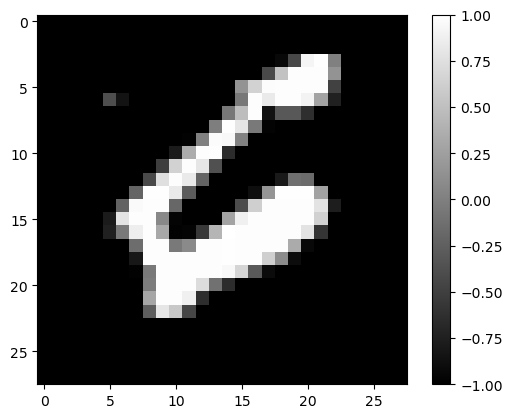

In [32]:
import matplotlib.pyplot as plt
import numpy as np

tensor_data = test.cpu().detach().numpy()
tensor_data = np.reshape(tensor_data,(28,28))

plt.imshow(tensor_data,cmap = 'gray')
plt.colorbar()
plt.show()